In [1]:
#Import packages
import pandas as pd 
import numpy as np
import eikon as ek
import yfinance as yf
import seaborn as sns 
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm
import scipy.stats as stats

## Test for Normality (Gaussainity)

In [2]:
#Download data
ek.set_app_key('4a3e5a3b0ff943d68f2a79e37cf828fe4354b99e')

df = ek.get_timeseries('WMT',
                      fields="CLOSE",
                      start_date = '2010-01-01',
                      end_date = "2022-01-01")


df = df[['CLOSE']].rename(columns={'CLOSE': 'Close'})
df['log_rtn'] = np.log(df.Close/df.Close.shift(1))
df = df[['Close', 'log_rtn']].dropna(how = 'any')

In [3]:
#Calculate the normal Probability Density Function (PDF) using the mean and standard deviation of the observed returns

r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)   

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


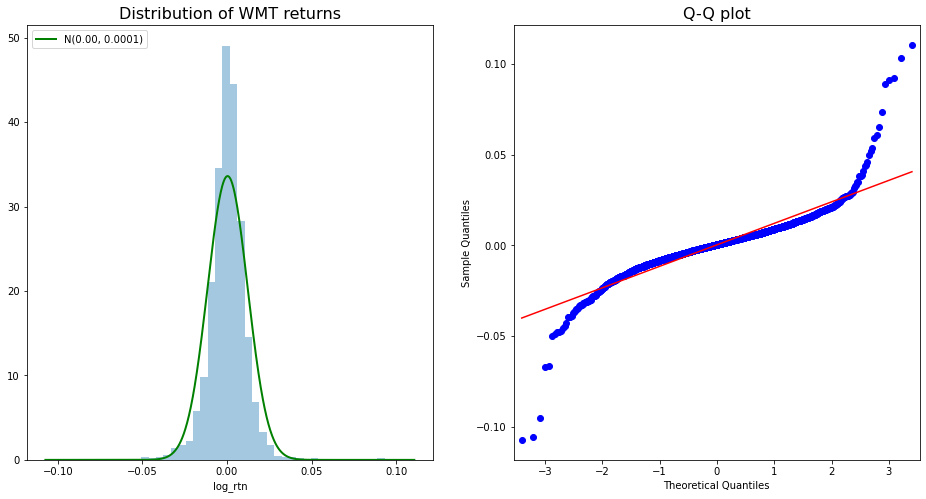

In [4]:
#Plot the histogram and the Q-Q Plot:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])                                    
ax[0].set_title('Distribution of WMT returns', fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, 'g', lw=2, 
           label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

#plt.tight_layout()
# plt.savefig('QQPLOT.png')
plt.show()

In [5]:
#Print summary statistics and check if the returns are normally distributed.

jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}')
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}') 
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------- Descriptive Statistics ----------
Range of dates: 2010-02-04 - 2021-12-31
Number of observations: 2999
Mean: 0.0003
Median: 0.0005
Min: -0.1074
Max: 0.1107
Standard Deviation: 0.0119
Skewness: 0.1947
Kurtosis: 15.9108
Jarque-Bera statistic: 31539.26 with p-value: 0.00


### Kolmogorov Smirnov Test

In [6]:
end = dt.datetime(2022,1,1)
start = dt.datetime(2010,1,1)

df = pdr.get_data_yahoo("WMT",start,end)

In [7]:
log_rets = np.log(df.Close/df.Close.shift(1)).dropna()
log_rets

Date
2010-01-05   -0.010008
2010-01-06   -0.002238
2010-01-07    0.000560
2010-01-08   -0.005050
2010-01-11    0.016366
                ...   
2021-12-27    0.009063
2021-12-28    0.014249
2021-12-29   -0.000490
2021-12-30    0.003218
2021-12-31    0.010561
Name: Close, Length: 3020, dtype: float64

In [8]:
ks_stat,p_value = stats.kstest(log_rets, 'norm')
print(ks_stat,p_value)
if p_value > 0.05:
    print('Probably Gaussian')
else:
    print('Probably NOT Gaussian')

0.4798830382203052 0.0
Probably NOT Gaussian


### Shapiro Wilk Test

In [14]:
sw_stat,p_value = stats.shapiro(log_rets)
print(sw_stat,p_value)
if p_value > 0.05:
    print('Probably Gaussian')
else:
    print('Probably NOT Gaussian')

0.8716265559196472 1.961817850054744e-44
Probably NOT Gaussian


## Volatility Clustering

In [10]:
#Download data
ek.set_app_key('4a3e5a3b0ff943d68f2a79e37cf828fe4354b99e')

df = ek.get_timeseries('WMT',
                      fields="CLOSE",
                      start_date = '2010-01-01',
                      end_date = "2022-01-01")


df = df[['CLOSE']].rename(columns={'CLOSE': 'Close'})
df['log_rtn'] = np.log(df.Close/df.Close.shift(1))
df = df[['Close', 'log_rtn']].dropna(how = 'any')

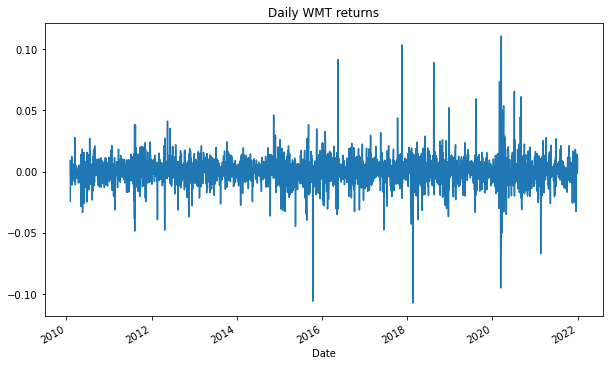

In [11]:
#Volatility Clustering
df.log_rtn.plot(title='Daily WMT returns', figsize=(10, 6))

# plt.tight_layout()
# plt.savefig('volatility.png')
plt.show()

## Absence of autocorrelation

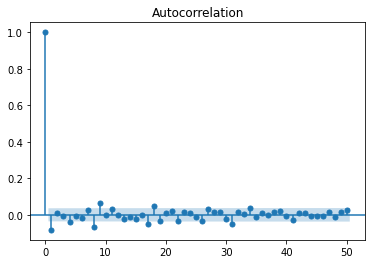

In [12]:
#Absence of autocorrelation in returns
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

acf = smt.graphics.plot_acf(df.log_rtn, 
                            lags=N_LAGS, 
                            alpha=SIGNIFICANCE_LEVEL)

# plt.tight_layout()
# plt.savefig('autocorrelation.png')
plt.show()

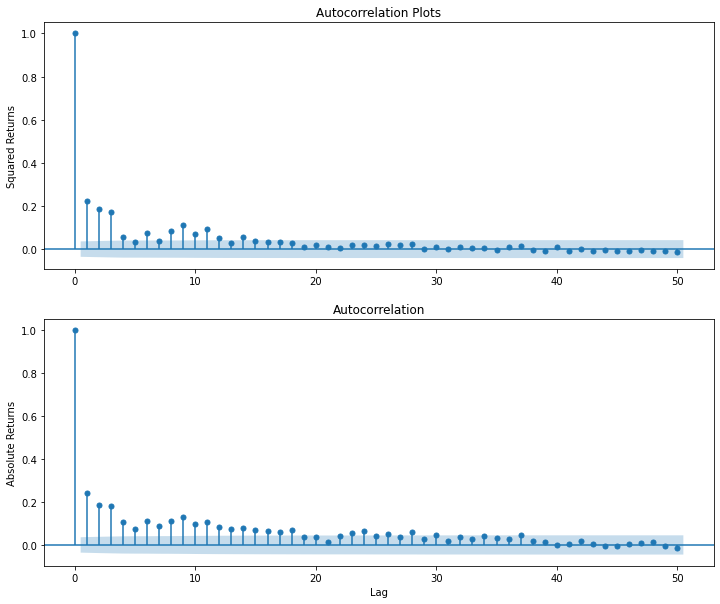

In [13]:
#Small and decreasing autocorrelation in squared/absolute returns
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

smt.graphics.plot_acf(df.log_rtn ** 2, lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelation Plots',
          ylabel='Squared Returns')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',
          xlabel='Lag')

# plt.tight_layout()
# plt.savefig('decreasingauto.png')
plt.show()